In [47]:
import torch
from torch import nn, optim

from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [48]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


In [49]:
args = {
    "batch_size": 20,
    "num_workers": 2,
    "num_classes": 10,
    "lr": 1e-4,
    "weight_decay": 5e-4,
    "num_epochs": 200
}

# Load Dataset

https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

Attribute Information:

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered



In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
!unzip Bike-Sharing-Dataset.zip

--2021-11-30 02:37:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip.1’

Bike-Sharing-Datase 100%[===================>] 273.43K   424KB/s    in 0.6s    

2021-11-30 02:37:04 (424 KB/s) - ‘Bike-Sharing-Dataset.zip.1’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
replace Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Readme.txt              
replace day.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: day.csv                 
replace hour.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hour.csv                


In [5]:
!ls

Bike-Sharing-Dataset.zip    day.csv   Readme.txt
Bike-Sharing-Dataset.zip.1  hour.csv  sample_data


# DataViz

In [50]:
df = pd.read_csv('hour.csv')
print(df.shape)
df.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Dataset split

https://pytorch.org/docs/stable/generated/torch.randperm.html

In [51]:
torch.manual_seed(10)

# train set = 80%
train_size = int(0.8 * df.shape[0])

# random rows
idx = torch.randperm(df.shape[0]).tolist()

df_train = df.iloc[idx[:train_size]]
df_test = df.iloc[idx[train_size:]]

print('train samples: {}, test samples: {}'.format(df_train.shape[0], df_test.shape[0]))

train samples: 13903, test samples: 3476


In [52]:
df_train.to_csv('bike_train.csv', index=False)
df_test.to_csv('bike_test.csv', index=False)

# Build dataset

In [53]:
class MyDataset(Dataset):
    def __init__(self, csv_path:str):
        
        self.data = pd.read_csv(csv_path).to_numpy()

    def __getitem__(self, idx):
        
        # only 2:14 columns
        sample = self.data[idx][2:14]
        label = self.data[idx][-1:]

        # convert to tensor
        sample = torch.from_numpy(sample.astype(np.float32))
        label = torch.from_numpy(label.astype(np.float32))
        
        return sample, label

    def __len__(self):
        return len(self.data)

In [54]:
# TEST CELL
train_set = MyDataset('bike_train.csv')
test_set = MyDataset('bike_test.csv')

train_loader = DataLoader(
    train_set,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=args['num_workers']
)

test_loader = DataLoader(
    test_set,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=args['num_workers']
)

for data, label in train_loader:
    print('data: {}\nlabel: {}'.format(data.size(), label.size()))
    break

data: torch.Size([20, 12])
label: torch.Size([20, 1])


# MLP

In [55]:
class MLP(nn.Module):

    def __init__(self, input_size, hidden_size, out_size):
        super(MLP, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        self.output = nn.Linear(hidden_size, out_size)
        # self.softmax = nn.Sigmoid()

    def forward(self, X):
        feature = self.features(X)
        output = self.output(feature)

        return output

In [56]:
net_params = {
    'input_size': len(train_set[0][0]),  # number of features
    'hidden_size': 128,
    'out_size': 1
}

model = MLP(**net_params).to(device)

# Train and Validate

In [57]:
criterion = nn.L1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [58]:
def train(model, dataloader, criterion, optimizer):

    model.train()
    epoch_loss = []

    for data_, label_ in dataloader:
        data, label = data_.to(device), label_.to(device)

        # forward
        pred = model(data)
        loss = criterion(pred, label)
        epoch_loss.append(loss.cpu().data)

        # barckward
        loss.backward()
        optimizer.step()

    epoch_loss = np.asarray(epoch_loss)
    print('loss: %3f +/- %3f' % (epoch_loss.mean(), epoch_loss.std()))

    return epoch_loss.mean()


In [59]:
def validate(model, dataloader, criterion, optimizer):

    model.eval()
    epoch_loss = []

    with torch.no_grad():
        for data_, label_ in dataloader:
            data, label = data_.to(device), label_.to(device)

            # forward
            pred = model(data)
            loss = criterion(pred, label)
            epoch_loss.append(loss.cpu().data)


    epoch_loss = np.asarray(epoch_loss)
    print('val_loss: %3f +/- %3f' % (epoch_loss.mean(), epoch_loss.std()))

    return epoch_loss.mean()


In [60]:
for c in range(args['num_epochs']):
    print('epoch {}/{}'.format(c, args['num_epochs']))
    train(model,train_loader, criterion, optimizer )
    validate(model, test_loader, criterion, optimizer)
    print('')

epoch 0/200
loss: 151.504868 +/- 39.518181
val_loss: 137.265900 +/- 22.671459

epoch 1/200
loss: 126.839409 +/- 30.257511
val_loss: 117.843552 +/- 28.354454

epoch 2/200
loss: 121.066429 +/- 27.475492
val_loss: 118.355309 +/- 31.488829

epoch 3/200
loss: 121.581490 +/- 30.689171
val_loss: 122.218185 +/- 24.818104

epoch 4/200
loss: 118.986191 +/- 30.199825
val_loss: 114.549835 +/- 27.208967

epoch 5/200
loss: 111.948814 +/- 26.635614
val_loss: 104.134766 +/- 28.183365

epoch 6/200
loss: 107.556610 +/- 27.700117
val_loss: 102.131462 +/- 21.178625

epoch 7/200
loss: 101.227699 +/- 28.353651
val_loss: 98.621193 +/- 18.836142

epoch 8/200
loss: 99.544022 +/- 26.963415
val_loss: 94.738632 +/- 22.511551

epoch 9/200
loss: 97.539085 +/- 25.615107
val_loss: 90.558357 +/- 21.686594

epoch 10/200
loss: 96.111061 +/- 23.545460
val_loss: 88.323090 +/- 24.758808

epoch 11/200
loss: 94.374260 +/- 23.564030
val_loss: 96.402344 +/- 27.724279

epoch 12/200
loss: 93.306778 +/- 24.994318
val_loss: 86.549

In [61]:
X_test= (torch.stack([x[0] for x in test_set])).to(device)

y_test= (torch.stack([x[1] for x in test_set])).to(device)

y_pred = model(X_test).cpu().data

In [62]:
df_results = pd.DataFrame(
    data=torch.cat((y_test, y_pred), axis=1),
    columns={'y_test','y_pred'}
)
df_results

,y_test,y_pred
0,tensor(398.),tensor(425.2493)
1,tensor(10.),tensor(112.7907)
2,tensor(172.),tensor(217.5704)
3,tensor(263.),tensor(221.9827)
4,tensor(312.),tensor(272.6280)
...,...,...
3471,tensor(108.),tensor(152.3598)
3472,tensor(206.),tensor(90.1718)
3473,tensor(420.),tensor(191.9801)
3474,tensor(38.),tensor(8.7867)


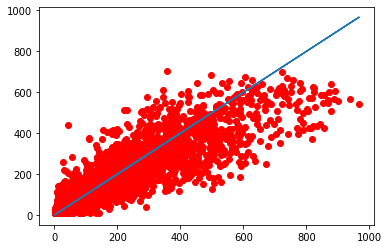

In [78]:
idx = torch.argsort(y_test, dim=0)

plt.plot(y_test, y_test)
plt.scatter(y_test[idx], y_pred[idx], color= 'red')